**Project Overview**

Built a bank-style credit risk model to predict probability of default and translate predictions into profit-maximizing underwriting decisions.

**Data & Modeling**

Dataset: Give Me Some Credit

Model: Logistic Regression (interpretable, regulator-friendly)

Features: Delinquency history, utilization, debt ratio, income, missing-value indicators

Performance: AUC ≈ 0.86, KS ≈ 0.55

**Policy Design**

Applicants were ranked by predicted PD and grouped into risk deciles. Multiple approval cutoffs were simulated to analyze tradeoffs between approval rate, default rate, and expected loss.

**Profit Optimization**

Using Expected Loss = PD × LGD × EAD and assumed revenue per loan, underwriting policies were evaluated on **profit per applicant**. The profit-maximizing policy was to reject the top 10% riskiest applicants.

**Sensitivity Analysis**

Demonstrated that optimal cutoffs become more restrictive as revenue decreases and less restrictive as revenue increases, highlighting the dependence of credit policy on pricing and margins.

In [4]:
import pandas as pd

train_path = "/content/sample_data/GiveMeSomeCredit-training.csv"
df = pd.read_csv(train_path)

print("Shape (r, c):", df.shape)
print("\ncolumns:")
print(df.columns.tolist())

print("\nfirst 5 rows:")
print(df.head().to_string(index=False))

Shape (r, c): (150000, 12)

columns:
['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

first 5 rows:
 Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents
          1                 1                              0.766127   45                                     2   0.802982         9120.0                               13                        0                             6                                     0                 2.0
          2                 0                              0.957151   40  

In [5]:
y = df["SeriousDlqin2yrs"]
X = df.drop(["SeriousDlqin2yrs"], axis=1)

print("target shape:", y.shape)
print("features shape:", X.shape)

print("\nfeature columns:")
print(X.columns.tolist())

target shape: (150000,)
features shape: (150000, 11)

feature columns:
['Unnamed: 0', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [6]:
# Percentage of missing values in each feature
missing_pct = X.isna().mean().sort_values(ascending=False)

print("Missing value percentage per column:")
print((missing_pct * 100).round(2).to_string())

# Basic summary statistics to spot outliers
summary = X.describe().T[["min", "50%", "max"]]
print(summary.to_string())

print("Minimum age:", X["age"].min())
print("Count of age <= 0:", (X["age"] <= 0).sum())

Missing value percentage per column:
MonthlyIncome                           19.82
NumberOfDependents                       2.62
Unnamed: 0                               0.00
age                                      0.00
RevolvingUtilizationOfUnsecuredLines     0.00
DebtRatio                                0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
                                      min           50%        max
Unnamed: 0                            1.0  75000.500000   150000.0
RevolvingUtilizationOfUnsecuredLines  0.0      0.154181    50708.0
age                                   0.0     52.000000      109.0
NumberOfTime30-59DaysPastDueNotWorse  0.0      0.000000       98.0
DebtRatio                             0.0      0.366508   329664.0
MonthlyIncome                         0.0   5400.000000

In [8]:
import numpy as np

# Make a copy so we don’t overwrite the original
df_clean = df.copy()

# 1. Drop ID column
df_clean = df_clean.drop(columns=["Unnamed: 0"])

# 2. Fix invalid age
df_clean.loc[df_clean["age"] <= 0, "age"] = np.nan

# 3. Replace delinquency placeholders with missing
delinq_cols = [
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate"
]

for col in delinq_cols:
    df_clean.loc[df_clean[col].isin([96, 98]), col] = np.nan

    # 4. Cap extreme values
df_clean["RevolvingUtilizationOfUnsecuredLines"] = df_clean[
    "RevolvingUtilizationOfUnsecuredLines"
].clip(lower=0, upper=1.5)

debt_cap = df_clean["DebtRatio"].quantile(0.99)
df_clean["DebtRatio"] = df_clean["DebtRatio"].clip(lower=0, upper=debt_cap)


# 5. Create missing indicators
for col in ["MonthlyIncome", "NumberOfDependents"] + delinq_cols:
    df_clean[col + "_missing"] = df_clean[col].isna().astype(int)


# Separate target and features again
y = df_clean["SeriousDlqin2yrs"]
X = df_clean.drop(columns=["SeriousDlqin2yrs"])

print("Cleaned feature shape:", X.shape)
print("\nMissing % after cleaning:")
print((X.isna().mean() * 100).round(2).to_string())

print("MonthlyIncome missing %:")
print(df_clean["MonthlyIncome"].isna().mean() * 100)

print("\nMonthlyIncome_missing value counts:")
print(df_clean["MonthlyIncome_missing"].value_counts())



Cleaned feature shape: (150000, 15)

Missing % after cleaning:
RevolvingUtilizationOfUnsecuredLines             0.00
age                                              0.00
NumberOfTime30-59DaysPastDueNotWorse             0.18
DebtRatio                                        0.00
MonthlyIncome                                   19.82
NumberOfOpenCreditLinesAndLoans                  0.00
NumberOfTimes90DaysLate                          0.18
NumberRealEstateLoansOrLines                     0.00
NumberOfTime60-89DaysPastDueNotWorse             0.18
NumberOfDependents                               2.62
MonthlyIncome_missing                            0.00
NumberOfDependents_missing                       0.00
NumberOfTime30-59DaysPastDueNotWorse_missing     0.00
NumberOfTime60-89DaysPastDueNotWorse_missing     0.00
NumberOfTimes90DaysLate_missing                  0.00
MonthlyIncome missing %:
19.820666666666668

MonthlyIncome_missing value counts:
MonthlyIncome_missing
0    120269
1     29731


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Bank-style modeling pipeline
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

# Train model
model.fit(X_train, y_train)

# Predict probabilities
val_probs = model.predict_proba(X_val)[:, 1]

# Evaluate ranking power
auc = roc_auc_score(y_val, val_probs)
print("Validation AUC:", round(auc, 4))


Validation AUC: 0.8605


In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, val_probs)

ks = np.max(tpr - fpr)
print("KS statistic:", round(ks, 4))


KS statistic: 0.5624


In [11]:
# Create a validation dataframe
val_df = pd.DataFrame({
    "predicted_pd": val_probs,
    "actual_default": y_val.values
})

# Create 10 risk deciles (1 = lowest risk, 10 = highest risk)
val_df["decile"] = pd.qcut(
    val_df["predicted_pd"],
    10,
    labels=False
) + 1

# Summarize by decile
decile_summary = (
    val_df
    .groupby("decile")
    .agg(
        avg_predicted_pd=("predicted_pd", "mean"),
        actual_default_rate=("actual_default", "mean"),
        count=("actual_default", "size")
    )
    .reset_index()
)

print(decile_summary)


   decile  avg_predicted_pd  actual_default_rate  count
0       1          0.097863             0.004000   3000
1       2          0.134204             0.006333   3000
2       3          0.164283             0.009000   3000
3       4          0.195337             0.013333   3000
4       5          0.231389             0.017667   3000
5       6          0.282371             0.027667   3000
6       7          0.361454             0.047333   3000
7       8          0.471439             0.064333   3000
8       9          0.607740             0.113000   3000
9      10          0.857089             0.365667   3000


In [12]:
# Simulate rejecting the top 20% riskiest applicants

cutoff = val_df["predicted_pd"].quantile(0.80)

val_df["approved"] = val_df["predicted_pd"] < cutoff

approval_rate = val_df["approved"].mean()
default_rate_approved = val_df.loc[val_df["approved"], "actual_default"].mean()
default_rate_overall = val_df["actual_default"].mean()

print("Approval rate:", round(approval_rate * 100, 2), "%")
print("Default rate (approved only):", round(default_rate_approved * 100, 2), "%")
print("Overall default rate:", round(default_rate_overall * 100, 2), "%")


Approval rate: 80.0 %
Default rate (approved only): 2.37 %
Overall default rate: 6.68 %


In [13]:
# Assumptions
LGD = 0.60
EAD = 10000  # $10,000 per loan

# Expected loss BEFORE cutoff (approve everyone)
EL_before = default_rate_overall * LGD * EAD

# Expected loss AFTER cutoff (approved only)
EL_after = default_rate_approved * LGD * EAD

reduction_pct = (1 - EL_after / EL_before) * 100

print("Expected loss per loan BEFORE cutoff: $", round(EL_before, 2))
print("Expected loss per loan AFTER cutoff:  $", round(EL_after, 2))
print("Expected loss reduction:", round(reduction_pct, 2), "%")


Expected loss per loan BEFORE cutoff: $ 401.0
Expected loss per loan AFTER cutoff:  $ 142.25
Expected loss reduction: 64.53 %


In [14]:
LGD = 0.60
EAD = 10000

# Baseline (approve everyone)
baseline_default_rate = val_df["actual_default"].mean()
baseline_EL_per_loan = baseline_default_rate * LGD * EAD

cutoffs = [0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.60, 0.50]
# 0.80 means approve bottom 80% (reject top 20%)

rows = []

for q in cutoffs:
    threshold = val_df["predicted_pd"].quantile(q)
    approved = val_df["predicted_pd"] < threshold

    approval_rate = approved.mean()
    default_rate_approved = val_df.loc[approved, "actual_default"].mean()

    EL_per_approved_loan = default_rate_approved * LGD * EAD
    EL_reduction_vs_baseline = (1 - (EL_per_approved_loan / baseline_EL_per_loan)) * 100

    rows.append({
        "approve_bottom_%": int(q * 100),
        "approval_rate_%": round(approval_rate * 100, 2),
        "default_rate_approved_%": round(default_rate_approved * 100, 2),
        "EL_per_approved_loan_$": round(EL_per_approved_loan, 2),
        "EL_reduction_vs_approve_all_%": round(EL_reduction_vs_baseline, 2)
    })

policy_table = pd.DataFrame(rows)
print("Baseline default rate (%):", round(baseline_default_rate * 100, 2))
print("Baseline EL per loan ($):", round(baseline_EL_per_loan, 2))
print("\nPolicy Curve Table:")
print(policy_table.to_string(index=False))


Baseline default rate (%): 6.68
Baseline EL per loan ($): 401.0

Policy Curve Table:
 approve_bottom_%  approval_rate_%  default_rate_approved_%  EL_per_approved_loan_$  EL_reduction_vs_approve_all_%
               95             95.0                     4.51                  270.74                          32.48
               90             90.0                     3.36                  201.78                          49.68
               85             85.0                     2.81                  168.71                          57.93
               80             80.0                     2.37                  142.25                          64.53
               75             75.0                     2.02                  121.07                          69.81
               70             70.0                     1.79                  107.43                          73.21
               60             60.0                     1.30                   78.00                          8

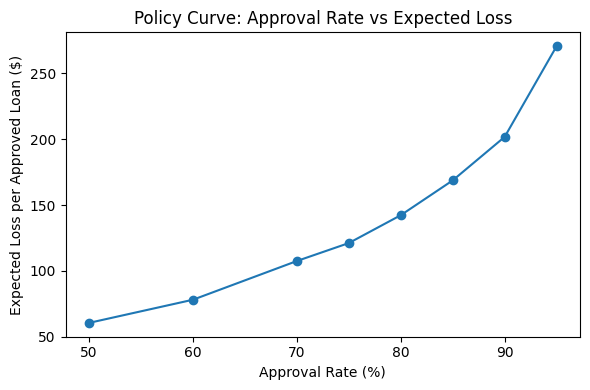

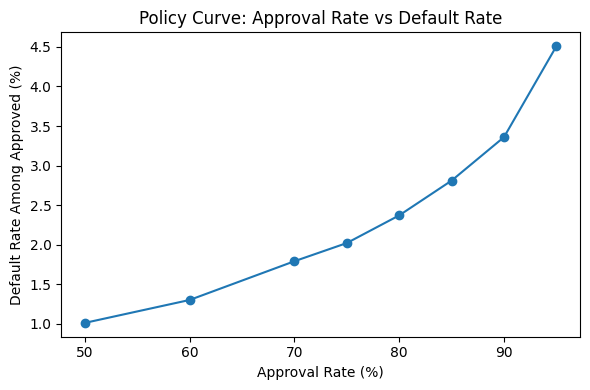

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(policy_table["approval_rate_%"], policy_table["EL_per_approved_loan_$"], marker="o")
plt.xlabel("Approval Rate (%)")
plt.ylabel("Expected Loss per Approved Loan ($)")
plt.title("Policy Curve: Approval Rate vs Expected Loss")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(policy_table["approval_rate_%"], policy_table["default_rate_approved_%"], marker="o")
plt.xlabel("Approval Rate (%)")
plt.ylabel("Default Rate Among Approved (%)")
plt.title("Policy Curve: Approval Rate vs Default Rate")
plt.tight_layout()
plt.show()


In [16]:
# Simple profit model assumptions (tweakable)
REVENUE_PER_APPROVED_LOAN = 900  # example: expected net interest + fees

policy_table["profit_per_approved_loan_$"] = (
    REVENUE_PER_APPROVED_LOAN - policy_table["EL_per_approved_loan_$"]
)

# Profit per applicant accounts for approvals dropping
policy_table["profit_per_applicant_$"] = (
    policy_table["profit_per_approved_loan_$"] * (policy_table["approval_rate_%"] / 100)
)

print(policy_table[[
    "approve_bottom_%",
    "approval_rate_%",
    "default_rate_approved_%",
    "EL_per_approved_loan_$",
    "profit_per_approved_loan_$",
    "profit_per_applicant_$"
]].to_string(index=False))


 approve_bottom_%  approval_rate_%  default_rate_approved_%  EL_per_approved_loan_$  profit_per_approved_loan_$  profit_per_applicant_$
               95             95.0                     4.51                  270.74                      629.26                597.7970
               90             90.0                     3.36                  201.78                      698.22                628.3980
               85             85.0                     2.81                  168.71                      731.29                621.5965
               80             80.0                     2.37                  142.25                      757.75                606.2000
               75             75.0                     2.02                  121.07                      778.93                584.1975
               70             70.0                     1.79                  107.43                      792.57                554.7990
               60             60.0              

In [17]:
revenues = [600, 900, 1200]  # low / base / high revenue cases

results = []

for rev in revenues:
    tmp = policy_table.copy()
    tmp["profit_per_approved_loan_$"] = rev - tmp["EL_per_approved_loan_$"]
    tmp["profit_per_applicant_$"] = tmp["profit_per_approved_loan_$"] * (tmp["approval_rate_%"] / 100)

    best_row = tmp.sort_values("profit_per_applicant_$", ascending=False).iloc[0]
    results.append({
        "revenue_per_approved_loan_$": rev,
        "best_policy_approve_bottom_%": int(best_row["approve_bottom_%"]),
        "best_profit_per_applicant_$": round(float(best_row["profit_per_applicant_$"]), 2)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


 revenue_per_approved_loan_$  best_policy_approve_bottom_%  best_profit_per_applicant_$
                         600                            85                        366.6
                         900                            90                        628.4
                        1200                            90                        898.4
